In [1]:
#@title Copyright 2020 Google LLC. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction to Neural Nets

This Colab builds a deep neural network to perform more sophisticated linear regression than the earlier Colabs.

## Learning Objectives:

After doing this Colab, you'll know how to do the following:

  * Create a simple deep neural network.
  * Tune the hyperparameters for a simple deep neural network.

## The Dataset
  
Like several of the previous Colabs, this Colab uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Import relevant modules

The following hidden code cell imports the necessary code to run the code in the rest of this Colaboratory.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# the following lines adjust the granularity of reporting 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Import modules")

Import modules


## Load the dataset

Like most of the previous Colab exercises, this exercise uses the California Housing Dataset.  The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set
   

In [4]:
train_df = pd.read_csv("california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("california_housing_test.csv")

## Normalize values

When building a model with multiple features, the values of each feature should cover roughly the same range.  The following code cell normalizes datasets by converting each raw value to its Z-score. (For more information about Z-scores, see the Classification exercise.)

In [5]:
# calculate the Z-scores of each column in the training set
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# calculate the Z-scores of each column in the test set
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values")

Normalized the values


## Represent data

The following code cell creates a feature layer containing three features:

* `latitude` X `longitude` (a feature cross)
* `median_income`
* `population`

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `my_feature_layer`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 

In [6]:
# create an empty list that will eventually hold all create feature columns
feature_columns = []

# we scaled all the columns, including latitude and longitude, into their Z-score. So, instead picking a resolution in degrees, we're going to use resolution_in_Zs. A resolution_in_Zs corresponds to a full standard deviation
resolution_in_Zs = 0.3 # 3/10 of standard deviation

# create a bucket feature column for latitude
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), int(max(train_df_norm['latitude'])), resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# create a bucket feature columns for longitude
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), int(max(train_df_norm['longitude'])), resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

# create a feature cross of latitude and longitude
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

# represent median income as a floating point value
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# convert the list of feature columns into a layer that will later be fed into the model
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## Build a linear regression model as a baseline

Before creating a deep neural net, find a [baseline](https://developers.google.com/machine-learning/glossary/#baseline) loss by running a simple linear regression model that uses the feature layer you just created.

In [7]:
def plot_the_loss_curve(epochs, mse):
    # plot a curve of loss vs epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max()*1.03])
    plt.show()

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [8]:
def create_model(my_learning_rate, feature_layer):
    # create and compile a simple linear regression model
    # most simple tf.keras models are sequential
    model = tf.keras.models.Sequential()

    # add the layer containing the feature columns to the model
    model.add(feature_layer)

    # add one linear layer to the model to yield a simple linear regressor
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

    # construct the layers into a model that Tensorflow can execute
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

def train_model(model, dataset, epochs, batch_size, label_name):
    # Feed dataset into the model in order to train it

    # split the dataset into features and label
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)

    # get details that will be useful for plotting the loss curve
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    rmse = hist["mean_squared_error"]

    return epochs, rmse

print("Defined the create_model and training_model functions")

Defined the create_model and training_model functions


Run the following code cell to invoke the the functions defined in the preceding two code cells. (Ignore the warning messages.)

**Note:** Because we've scaled all the input data, **including the label**, the resulting loss values will be *much less* than previous models. 

**Note:** Depending on the version of TensorFlow, running this cell might generate WARNING messages. Please ignore these warnings. 

Epoch 1/15
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 3ms/step - loss: 1.0001 - mean_squared_error: 1.0001
Epoch 2/15
17/17 [==============================] - 0s 3ms/step - loss: 0.6505 - mean_squared_error: 0.6505
Epoch 3/15
17/17 [==============================] - 0s 2ms/step - loss: 0.4956 - mean_squared_error: 0.4956
Epoch 4/15
17/17 [==============================] - 0s 2ms/step - loss: 0.4191 - mean_squared_error: 0.4191
Epoch 5/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3690 - mean_squared_error: 0.3690
Epoch 6/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3659 - mean_squared_error: 0.3659
Epoch 7/15
17/17 [==============================] - 0s 3ms/step - loss: 0.3555 - mean_squared_error: 0.3555
Epoch 8/15
17/17 [==============================] - 0s 3ms/step - loss: 0.3575 - mean_squared_error: 0.3575
Epoch 9/15
17/17 [========

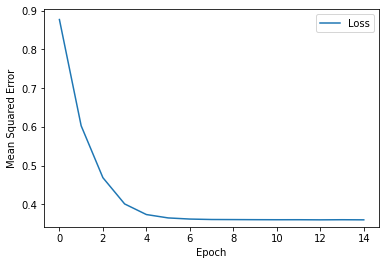


 Evaluate the linear regression model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 2ms/step - loss: 0.3960 - mean_squared_error: 0.3960


[0.3959640562534332, 0.3959640562534332]

In [9]:
# the following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# establish the model's topography
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

## Define a deep neural net model

The `create_model` function defines the topography of the deep neural net, specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.

The `create_model` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.

In [10]:
def create_model(my_learning_rate, my_feature_layer):
    # create and compile a simple linear regression model
    # most simple tf.keras models are sequential
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model
    model.add(my_feature_layer)

    # Describe the topography of the model by calling the tf.keras.layers.Dense method once for each layer. We've specified the following arguments:
    #   * units specifies the number of nodes in this layer
    #   * activation specifies the activation function (Rectified Linear Unit)
    #   * name is just a string that can be useful when debugging

    # Define the first hidden layer with 20 nodes
    model.add(tf.keras.layers.Dense(units=20, activation='relu', name='Hidden1'))

    # Define the second hidden layer with 12 nodes
    model.add(tf.keras.layers.Dense(units=12, activation='relu', name='Hidden2'))

    # Define the output layer
    model.add(tf.keras.layers.Dense(units=1, name='Output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

## Define a training function

The `train_model` function trains the model from the input features and labels. The [tf.keras.Model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit) method performs the actual training. The `x` parameter of the `fit` method is very flexible, enabling you to pass feature data in a variety of ways. The following implementation passes a Python dictionary in which:

* The *keys* are the names of each feature (for example, `longitude`, `latitude`, and so on).
* The *value* of each key is a NumPy array containing the values of that feature. 

**Note:** Although you are passing *every* feature to `model.fit`, most of those values will be ignored. Only the features accessed by `my_feature_layer` will actually be used to train the model.

In [12]:
def train_model(model, dataset, epochs, label_name, batch_size=None):
    # Train the model by feeding it data

    # Split the dataset into features and label
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)

    # the list of epochs is stored separately from the rest of history
    epochs = history.epoch

    # to track the progression of training, gather a snapshot of the model's mean squared error at each epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

## Call the functions to build and train a deep neural net

Okay, it is time to actually train the deep neural net.  If time permits, experiment with the three hyperparameters to see if you can reduce the loss
against the test set.


Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 4ms/step - loss: 0.7655 - mean_squared_error: 0.7655
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3801 - mean_squared_error: 0.3801
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3518 - mean_squared_error: 0.3518
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3508 - mean_squared_error: 0.3508
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3420 - mean_squared_error: 0.3420
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3368 - mean_squared_error: 0.3368
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3308 - mean_squared_error: 0.3308
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3381 - mean_squared_error: 0.3381
Epoch 9/20
17/17 [========

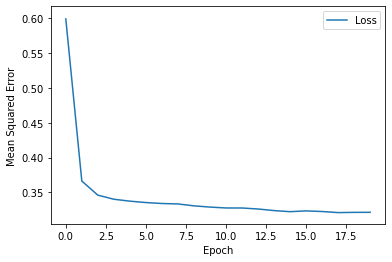


 evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 4ms/step - loss: 0.3641 - mean_squared_error: 0.3641


[0.36411434412002563, 0.36411434412002563]

In [13]:
# the following variables are the hyperparameter
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# establish the model's topography
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire normalized training set, but the model will only use the features defined by the feature_layer
epochs, mse = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

plot_the_loss_curve(epochs, mse)

# after building a model against the training set, test that model against the test set
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 1: Compare the two models

How did the deep neural net perform against the baseline linear regression model?

Kalo dilihat dari nilai mean squared errornya model neural network memiliki nilai lebih kecil, tapi perbedaanya tidak terlalu jauh, bisa aja di percobaan pelatihan selanjutnya nilai nya berbalik.

In [14]:
#@title Double-click to view a possible answer

# Assuming that the linear model converged and
# the deep neural net model also converged, please 
# compare the test set loss for each.
# In our experiments, the loss of the deep neural 
# network model was consistently lower than 
# that of the linear regression model, which 
# suggests that the deep neural network model 
# will make better predictions than the 
# linear regression model.

## Task 2: Optimize the deep neural network's topography

Experiment with the number of layers of the deep neural network and the number of nodes in each layer.  Aim to achieve both of the following goals:

*  Lower the loss against the test set.
*  Minimize the overall number of nodes in the deep neural net. 

The two goals may be in conflict.

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 3ms/step - loss: 0.8530 - mean_squared_error: 0.8530
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.4172 - mean_squared_error: 0.4172
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3444 - mean_squared_error: 0.3444
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3385 - mean_squared_error: 0.3385
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3334 - mean_squared_error: 0.3334
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3359 - mean_squared_error: 0.3359
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3233 - mean_squared_error: 0.3233
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3213 - mean_squared_error: 0.3213
Epoch 9/20
17/17 [========

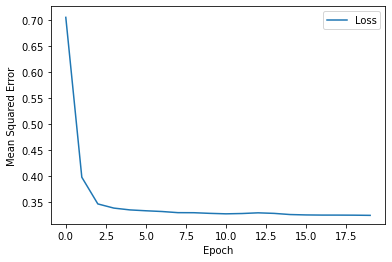


 evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 3ms/step - loss: 0.3657 - mean_squared_error: 0.3657


[0.3657148480415344, 0.3657148480415344]

In [15]:
def create_model(my_learning_rate, my_feature_layer):
    # create and compile a simple linear regression model
    # most simple tf.keras models are sequential
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model
    model.add(my_feature_layer)

    # Describe the topography of the model by calling the tf.keras.layers.Dense method once for each layer. We've specified the following arguments:
    #   * units specifies the number of nodes in this layer
    #   * activation specifies the activation function (Rectified Linear Unit)
    #   * name is just a string that can be useful when debugging

    # Define the first hidden layer with 20 nodes
    model.add(tf.keras.layers.Dense(units=12, activation='relu', name='Hidden1'))

    # Define the second hidden layer with 12 nodes
    model.add(tf.keras.layers.Dense(units=6, activation='relu', name='Hidden2'))

    model.add(tf.keras.layers.Dense(units=6, activation='relu', name='Hidden3'))

    # Define the output layer
    model.add(tf.keras.layers.Dense(units=1, name='Output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

def train_model(model, dataset, epochs, label_name, batch_size=None):
    # Train the model by feeding it data

    # Split the dataset into features and label
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)

    # the list of epochs is stored separately from the rest of history
    epochs = history.epoch

    # to track the progression of training, gather a snapshot of the model's mean squared error at each epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

# the following variables are the hyperparameter
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# establish the model's topography
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire normalized training set, but the model will only use the features defined by the feature_layer
epochs, mse = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

plot_the_loss_curve(epochs, mse)

# after building a model against the training set, test that model against the test set
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [16]:
#@title Double-click to view a possible answer

# Many answers are possible.  We noticed the 
# following trends:
#   * Two layers outperformed one layer, but 
#     three layers did not perform significantly 
#     better than two layers; two layers 
#     outperformed one layer.
#     In other words, two layers seemed best. 
#   * Setting the topography as follows produced 
#     reasonably good results with relatively few 
#     nodes:
#       * 10 nodes in the first layer.
#       *  6 nodes in the second layer.
#     As the number of nodes in each layer dropped
#     below the preceding, test loss increased.  
#     However, depending on your application, hardware
#     constraints, and the relative pain inflicted 
#     by a less accurate model, a smaller network 
#     (for example, 6 nodes in the first layer and 
#     4 nodes in the second layer) might be 
#     acceptable.

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 3ms/step - loss: 1.0348 - mean_squared_error: 1.0348
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.5355 - mean_squared_error: 0.5355
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3717 - mean_squared_error: 0.3717
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3438 - mean_squared_error: 0.3438
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3405 - mean_squared_error: 0.3405
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3338 - mean_squared_error: 0.3338
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3320 - mean_squared_error: 0.3320
Epoch 8/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3299 - mean_squared_error: 0.3299
Epoch 9/20
17/17 [========

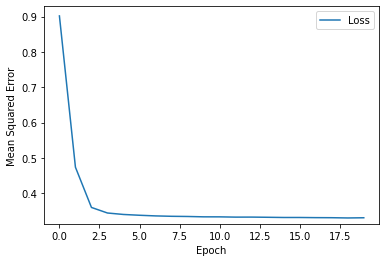


 evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 4ms/step - loss: 0.3741 - mean_squared_error: 0.3741


[0.3741115629673004, 0.3741115629673004]

In [17]:
def create_model(my_learning_rate, my_feature_layer):
    # create and compile a simple linear regression model
    # most simple tf.keras models are sequential
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model
    model.add(my_feature_layer)

    # Describe the topography of the model by calling the tf.keras.layers.Dense method once for each layer. We've specified the following arguments:
    #   * units specifies the number of nodes in this layer
    #   * activation specifies the activation function (Rectified Linear Unit)
    #   * name is just a string that can be useful when debugging

    # Define the first hidden layer with 20 nodes
    model.add(tf.keras.layers.Dense(units=10, activation='relu', name='Hidden1'))

    # Define the second hidden layer with 12 nodes
    model.add(tf.keras.layers.Dense(units=6, activation='relu', name='Hidden2'))

    # Define the output layer
    model.add(tf.keras.layers.Dense(units=1, name='Output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

def train_model(model, dataset, epochs, label_name, batch_size=None):
    # Train the model by feeding it data

    # Split the dataset into features and label
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)

    # the list of epochs is stored separately from the rest of history
    epochs = history.epoch

    # to track the progression of training, gather a snapshot of the model's mean squared error at each epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

# the following variables are the hyperparameter
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# establish the model's topography
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire normalized training set, but the model will only use the features defined by the feature_layer
epochs, mse = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

plot_the_loss_curve(epochs, mse)

# after building a model against the training set, test that model against the test set
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 2ms/step - loss: 0.6585 - mean_squared_error: 0.6585
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3988 - mean_squared_error: 0.3988
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3563 - mean_squared_error: 0.3563
Epoch 4/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3429 - mean_squared_error: 0.3429
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3431 - mean_squared_error: 0.3431
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3450 - mean_squared_error: 0.3450
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3390 - mean_squared_error: 0.3390
Epoch 8/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3373 - mean_squared_error: 0.3373
Epoch 9/20
17/17 [========

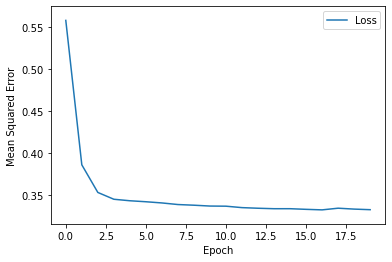


 evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 4ms/step - loss: 0.3739 - mean_squared_error: 0.3739


[0.3738575875759125, 0.3738575875759125]

In [18]:
def create_model(my_learning_rate, my_feature_layer):
    # create and compile a simple linear regression model
    # most simple tf.keras models are sequential
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model
    model.add(my_feature_layer)

    # Describe the topography of the model by calling the tf.keras.layers.Dense method once for each layer. We've specified the following arguments:
    #   * units specifies the number of nodes in this layer
    #   * activation specifies the activation function (Rectified Linear Unit)
    #   * name is just a string that can be useful when debugging

    # Define the first hidden layer with 20 nodes
    model.add(tf.keras.layers.Dense(units=6, activation='relu', name='Hidden1'))

    # Define the second hidden layer with 12 nodes
    model.add(tf.keras.layers.Dense(units=4, activation='relu', name='Hidden2'))

    # Define the output layer
    model.add(tf.keras.layers.Dense(units=1, name='Output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

def train_model(model, dataset, epochs, label_name, batch_size=None):
    # Train the model by feeding it data

    # Split the dataset into features and label
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)

    # the list of epochs is stored separately from the rest of history
    epochs = history.epoch

    # to track the progression of training, gather a snapshot of the model's mean squared error at each epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

# the following variables are the hyperparameter
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# establish the model's topography
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire normalized training set, but the model will only use the features defined by the feature_layer
epochs, mse = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

plot_the_loss_curve(epochs, mse)

# after building a model against the training set, test that model against the test set
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## implementin L1 regularization

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 2ms/step - loss: 1.5875 - mean_squared_error: 0.9682
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.7686 - mean_squared_error: 0.5873
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 0.5425 - mean_squared_error: 0.4124
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4822 - mean_squared_error: 0.3850
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4588 - mean_squared_error: 0.3741
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.4535 - mean_squared_error: 0.3730
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4448 - mean_squared_error: 0.3692
Epoch 8/20
17/17 [==============================] - 0s 6ms/step - loss: 0.4400 - mean_squared_error: 0.3652
Epoch 9/20
17/17 [========

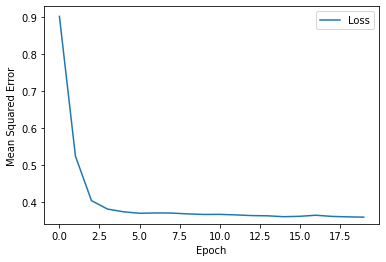


 evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 4ms/step - loss: 0.4574 - mean_squared_error: 0.3921


[0.4574100375175476, 0.39209774136543274]

In [19]:
def create_model(my_learning_rate, my_feature_layer):
    # create and compile a simple linear regression model
    # most simple tf.keras models are sequential
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model
    model.add(my_feature_layer)

    # Describe the topography of the model by calling the tf.keras.layers.Dense method once for each layer. We've specified the following arguments:
    #   * units specifies the number of nodes in this layer
    #   * activation specifies the activation function (Rectified Linear Unit)
    #   * name is just a string that can be useful when debugging

    # Define the first hidden layer with 20 nodes
    model.add(tf.keras.layers.Dense(units=6, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(l=0.01), name='Hidden1'))

    # Define the second hidden layer with 12 nodes
    model.add(tf.keras.layers.Dense(units=4, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(l=0.01), name='Hidden2'))

    # Define the output layer
    model.add(tf.keras.layers.Dense(units=1, name='Output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

def train_model(model, dataset, epochs, label_name, batch_size=None):
    # Train the model by feeding it data

    # Split the dataset into features and label
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)

    # the list of epochs is stored separately from the rest of history
    epochs = history.epoch

    # to track the progression of training, gather a snapshot of the model's mean squared error at each epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

# the following variables are the hyperparameter
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# establish the model's topography
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire normalized training set, but the model will only use the features defined by the feature_layer
epochs, mse = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

plot_the_loss_curve(epochs, mse)

# after building a model against the training set, test that model against the test set
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## implement l2 regularization

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 3ms/step - loss: 1.0776 - mean_squared_error: 0.9641
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5839 - mean_squared_error: 0.5326
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4402 - mean_squared_error: 0.3802
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.4091 - mean_squared_error: 0.3591
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 0.4026 - mean_squared_error: 0.3592
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3831 - mean_squared_error: 0.3439
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3795 - mean_squared_error: 0.3425
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3855 - mean_squared_error: 0.3507
Epoch 9/20
17/17 [========

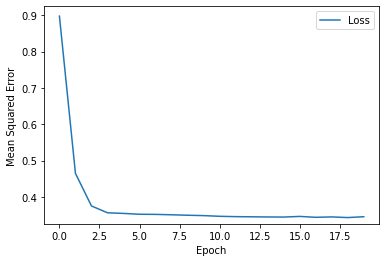


 evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 4ms/step - loss: 0.4060 - mean_squared_error: 0.3785


[0.40597429871559143, 0.37845128774642944]

In [20]:
def create_model(my_learning_rate, my_feature_layer):
    # create and compile a simple linear regression model
    # most simple tf.keras models are sequential
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model
    model.add(my_feature_layer)

    # Describe the topography of the model by calling the tf.keras.layers.Dense method once for each layer. We've specified the following arguments:
    #   * units specifies the number of nodes in this layer
    #   * activation specifies the activation function (Rectified Linear Unit)
    #   * name is just a string that can be useful when debugging

    # Define the first hidden layer with 20 nodes
    model.add(tf.keras.layers.Dense(units=6, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01), name='Hidden1'))

    # Define the second hidden layer with 12 nodes
    model.add(tf.keras.layers.Dense(units=4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01), name='Hidden2'))

    # Define the output layer
    model.add(tf.keras.layers.Dense(units=1, name='Output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

def train_model(model, dataset, epochs, label_name, batch_size=None):
    # Train the model by feeding it data

    # Split the dataset into features and label
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)

    # the list of epochs is stored separately from the rest of history
    epochs = history.epoch

    # to track the progression of training, gather a snapshot of the model's mean squared error at each epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

# the following variables are the hyperparameter
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# establish the model's topography
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire normalized training set, but the model will only use the features defined by the feature_layer
epochs, mse = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

plot_the_loss_curve(epochs, mse)

# after building a model against the training set, test that model against the test set
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [ ]:
def create_model(my_learning_rate, my_feature_layer):
    # create and compile a simple linear regression model
    # most simple tf.keras models are sequential
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model
    model.add(my_feature_layer)

    # Describe the topography of the model by calling the tf.keras.layers.Dense method once for each layer. We've specified the following arguments:
    #   * units specifies the number of nodes in this layer
    #   * activation specifies the activation function (Rectified Linear Unit)
    #   * name is just a string that can be useful when debugging

    # Define the first hidden layer with 20 nodes
    model.add(tf.keras.layers.Dense(units=6, activation='relu', name='Hidden1'))

    model.add(tf.keras.layers.Dropout(rate=0.25))
    
    # Define the second hidden layer with 12 nodes
    model.add(tf.keras.layers.Dense(units=4, activation='relu', name='Hidden2'))

    # Define the output layer
    model.add(tf.keras.layers.Dense(units=1, name='Output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

def train_model(model, dataset, epochs, label_name, batch_size=None):
    # Train the model by feeding it data

    # Split the dataset into features and label
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)

    # the list of epochs is stored separately from the rest of history
    epochs = history.epoch

    # to track the progression of training, gather a snapshot of the model's mean squared error at each epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

# the following variables are the hyperparameter
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# establish the model's topography
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire normalized training set, but the model will only use the features defined by the feature_layer
epochs, mse = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

plot_the_loss_curve(epochs, mse)

# after building a model against the training set, test that model against the test set
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)